In [69]:
import os
import numpy as np
from PIL import Image
from sklearn.preprocessing import OneHotEncoder
import matplotlib
from matplotlib import pyplot as plt
from tqdm import tqdm
import pandas as pd
# !pip install opencv-python-headless
import cv2
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import keras
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam, legacy

In [70]:
import os

# 设置工作目录为指定路径
desired_path = r'E:\GRADUATE REASERCH\ms course\7243\final project'
os.chdir(desired_path)

# 确认工作目录是否更改成功
print(f"当前工作目录已更改为: {os.getcwd()}")


当前工作目录已更改为: E:\GRADUATE REASERCH\ms course\7243\final project


In [71]:
### load in all the CSV's for each ICH

## THIS IS THE CORRECT WAY THAT WE NEED TO TRY, NOT LOADING FROM IMG DIRECTORY

EPH_df = pd.read_csv('Hemorrhage Segmentation Project/Results_Epidural Hemorrhage Detection_2020-11-16_21.31.26.148.csv') 
EPH_df = EPH_df[['Origin', 'Majority Label']]

#IVH_df = pd.read_csv('Hemorrhage Segmentation Project/Results_Brain Hemorrhage Tracing_2020-09-28_15.21.52.597.csv') # IVH
#IVH_df = IVH_df[['Origin', 'Majority Label']]

IPH_df = pd.read_csv('Hemorrhage Segmentation Project/Results_Intraparenchymal Hemorrhage Detection_2020-11-16_21.39.31.268.csv')
IPH_df = IPH_df[['Origin', 'Majority Label']]

SDH_df = pd.read_csv('Hemorrhage Segmentation Project/Results_Subdural Hemorrhage Detection_2020-11-16_21.35.48.040.csv')
SDH_df = SDH_df[['Origin', 'Majority Label']]

SAH_df = pd.read_csv('Hemorrhage Segmentation Project/Results_Subarachnoid Hemorrhage Detection_2020-11-16_21.36.18.668.csv')
SAH_df = SAH_df[['Origin', 'Majority Label']]

MCH_df = pd.read_csv('Hemorrhage Segmentation Project/Results_Multiple Hemorrhage Detection_2020-11-16_21.36.24.018.csv') # MCH
MCH_df = MCH_df[['Origin', 'Majority Label']]

In [72]:
EPH_filter = EPH_df['Majority Label'].notna()
EPH_filtered = EPH_df[EPH_filter]
len(EPH_filtered)
EPH_filtered

,Origin,Majority Label
0,ID_004c4b319.jpg,"[{""x"": 0.537109375, ""y"": 0.89453125}, {""x"": 0...."
1,ID_0237b835f.jpg,"[{""x"": 0.654296875, ""y"": 0.724609375}, {""x"": 0..."
2,ID_02e2d273d.jpg,"[{""x"": 0.46484375, ""y"": 0.357421875}, {""x"": 0...."
3,ID_02f37ce84.jpg,"[{""x"": 0.431640625, ""y"": 0.607421875}, {""x"": 0..."
4,ID_02f37ce84.jpg,"[{""x"": 0.353515625, ""y"": 0.59765625}, {""x"": 0...."
...,...,...
605,ID_879afbc77.jpg,[]
606,ID_af76460ee.jpg,[]
607,ID_d6d369eaa.jpg,[]
608,ID_d9bfa60ed.jpg,[]


In [73]:
print(SDH_df.columns)


Index(['Origin', 'Majority Label'], dtype='object')


In [74]:
SDH_df['Labeling State'].value_counts()

KeyError: 'Labeling State'

In [75]:
SDH_filter = SDH_df['Labeling State'] != 'In Progress'
SDH_filtered = SDH_df[EPH_filter]
len(SDH_filtered)
SDH_filtered

KeyError: 'Labeling State'

In [122]:
# Define your image directories
file_dir = 'renders/' 
ICH_types = ['normal', 'epidural', 'subarachnoid', 'intraparenchymal', 'subdural', 'intraventricular', 'multi']
windows = ["brain_bone_window", "brain_window", "max_contrast_window", "subdural_window"]

# Read flagged filenames from flagged.txt
with open('Hemorrhage Segmentation Project/flagged.txt', 'r') as f:
    flagged_files = set(line.strip() for line in f)  # Using a set for fast membership checking

#normal file_max is 6080 (since not same number of files in all windows)

# One Hot Encoding
encoder = OneHotEncoder()
encoder.fit([[0],[1],[2],[3],[4],[5],[6]])
target_shape = (512, 512, 3)

def load_images_from_directory(directory, label, target_shape, file_max=None):
    """Load images from a given directory, check shape, and apply one-hot encoding."""

    train_data = []
    # labels = []
    # wrong_files = []
    same_scan = set()
    
    # for dirname, _, filenames in os.walk(directory):
    filenames = os.listdir(directory)
    if file_max is None:
        file_max = len(filenames)
        
    true_file_max = file_max
        
    for filename in tqdm(filenames[0:file_max], desc=f'Loading images from {directory}', unit='file'):
        if filename in flagged_files:
            true_file_max -= 1
            continue
        else:
            img_path = os.path.join(directory, filename)
            img = Image.open(img_path)
            
            # Convert to array and check shape
            img_np = np.array(img)
            if img_np.shape != target_shape:
                # wrong_files.append(filename) 
                img = img.resize((512,512), Image.LANCZOS)  # Use LANCZOS for high-quality downsampling
               
            img = img.resize((256,256), Image.LANCZOS)  # Use LANCZOS for high-quality downsampling
            
            img_array = np.array(img)
            grayscale_img = img_array
            # grayscale_img = np.mean(img_array, axis=2)
            grayscale_img = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)
            train_data.append(grayscale_img)
            
            # if filename not in same_scan:
            #     labels.append(encoder.transform([[label]]).toarray()[0])
            
            same_scan.add(filename)
                
    return train_data, file_max


def main_loader(directory, windows, label, X_train_dict, y_train, target_shape, file_max=None):
    # Assuming ICH_types is defined somewhere above
    for i, slide in enumerate(windows):
        dir_path = os.path.join(directory, ICH_types[label], slide)  # Adjust path based on your directory structure
        
        # Use tqdm to show progress for the main loader
        print(f"Loading images for {slide}...")
        
        data, file_max = load_images_from_directory(dir_path, label, target_shape, file_max)  # Load images
        X_train_dict[slide].extend(data)  # Append data to the corresponding window

    ## THIS TAKES A LONG TIME FOR BIG ARRAYS
    print("Converting lists to numpy arrays:")
    for window in tqdm(windows, desc='Converting lists', unit='window'):
        X_train_dict[window] = np.array(X_train_dict[window])

    sample = encoder.transform([[label]]).toarray()
    labels = np.tile(sample, (file_max, 1))
    y_train = np.array(labels)
    
    return X_train_dict, y_train

def stack_slices(X_train_dict):
    # Get the windows to stack in the order you want
    windows_to_stack = [
        'brain_bone_window', 
        'brain_window', 
        'subdural_window', 
        'max_contrast_window'
    ]
    
    # Create an empty list to hold the stacked data
    stacked_data = []

    # Use tqdm to show progress for stacking
    for window in tqdm(windows_to_stack, desc='Stacking slices', unit='window'):
        stacked_data.append(X_train_dict[window])

    # Stack the windows along a new axis
    X_train = np.stack(stacked_data, axis=3)
    
    return X_train

# Input Struct
# Shape will be (N, 512, 512, 4)

In [123]:
NRM_train_dict = {window: [] for window in windows}  # Create a dictionary to hold data for each window
NRM_label = []  # This will hold the labels

NRM_train_dict, NRM_label = main_loader(file_dir, windows, 0, NRM_train_dict, NRM_label, target_shape, 1500)

NRM_train = stack_slices(NRM_train_dict)

Loading images for brain_bone_window...


Loading images from renders/normal\brain_bone_window: 100%|██████████| 1500/1500 [00:07<00:00, 190.00file/s]


Loading images for brain_window...


Loading images from renders/normal\brain_window: 100%|██████████| 1500/1500 [00:07<00:00, 202.35file/s]


Loading images for max_contrast_window...


Loading images from renders/normal\max_contrast_window: 100%|██████████| 1500/1500 [00:07<00:00, 197.79file/s]


Loading images for subdural_window...


Loading images from renders/normal\subdural_window: 100%|██████████| 1500/1500 [00:07<00:00, 197.17file/s]


Converting lists to numpy arrays:


Stacking slices: 100%|██████████| 4/4 [00:00<00:00, 4013.69window/s]


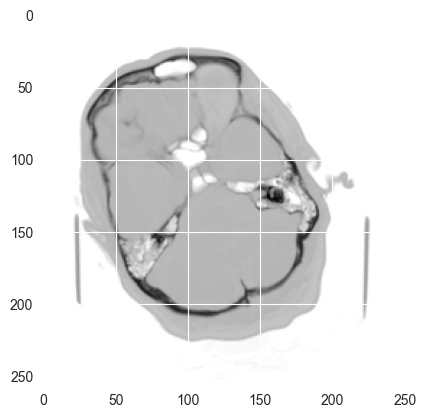

In [124]:
plt.imshow(NRM_train[0][:,:,0], cmap='binary')

# NRM_train[0][:, :, 0].shape

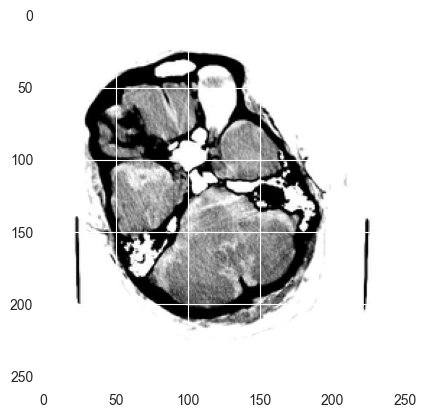

In [125]:
plt.imshow(NRM_train[0][:,:,1], cmap='binary')

In [128]:
# Load images for Epidural Hemorrhage

EDH_train_dict = {window: [] for window in windows}  # Create a dictionary to hold data for each window
EDH_label = []  # This will hold the labels


EDH_train_dict, EDH_label = main_loader(file_dir, windows, 1, EDH_train_dict, EDH_label, target_shape,1500)
EDH_train = stack_slices(EDH_train_dict)

sample = encoder.transform([[1]]).toarray()
labels = np.tile(sample, (len(EDH_train), 1))
EDH_label = np.array(labels)

Loading images for brain_bone_window...


Loading images from renders/epidural\brain_bone_window: 100%|██████████| 1500/1500 [00:06<00:00, 226.62file/s]


Loading images for brain_window...


Loading images from renders/epidural\brain_window: 100%|██████████| 1500/1500 [00:06<00:00, 222.19file/s]


Loading images for max_contrast_window...


Loading images from renders/epidural\max_contrast_window: 100%|██████████| 1500/1500 [00:07<00:00, 213.76file/s]


Loading images for subdural_window...


Loading images from renders/epidural\subdural_window: 100%|██████████| 1500/1500 [00:06<00:00, 221.67file/s]


Converting lists to numpy arrays:


Stacking slices: 100%|██████████| 4/4 [00:00<?, ?window/s]


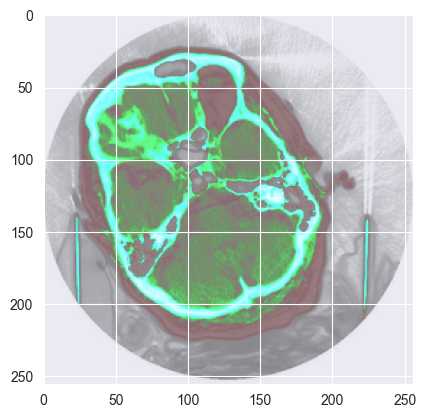

In [129]:
plt.imshow(NRM_train[0], cmap='binary')

In [130]:
# Load images for Subarachnoid Hemorrhage

SAH_train_dict = {window: [] for window in windows}  # Create a dictionary to hold data for each window
SAH_label = []  # This will hold the labels

SAH_train_dict, SAH_label = main_loader(file_dir, windows, 2, SAH_train_dict, SAH_label, target_shape, 1500)

SAH_train = stack_slices(SAH_train_dict)

Loading images for brain_bone_window...


Loading images from renders/subarachnoid\brain_bone_window: 100%|██████████| 1500/1500 [00:07<00:00, 206.76file/s]


Loading images for brain_window...


Loading images from renders/subarachnoid\brain_window: 100%|██████████| 1500/1500 [00:07<00:00, 191.93file/s]


Loading images for max_contrast_window...


Loading images from renders/subarachnoid\max_contrast_window: 100%|██████████| 1500/1500 [00:07<00:00, 194.01file/s]


Loading images for subdural_window...


Loading images from renders/subarachnoid\subdural_window: 100%|██████████| 1500/1500 [00:07<00:00, 200.35file/s]


Converting lists to numpy arrays:


Stacking slices: 100%|██████████| 4/4 [00:00<?, ?window/s]


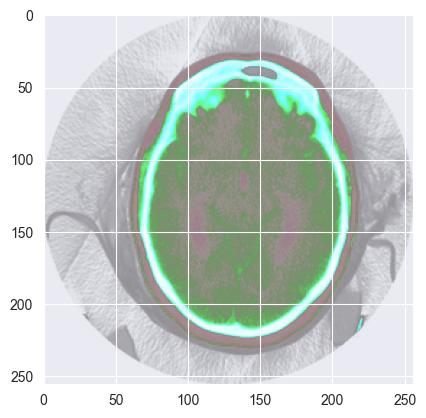

In [131]:
plt.imshow(SAH_train[0], cmap='binary')

In [132]:
# Load images for Intraparenchymal Hemorrhage

IPH_train_dict = {window: [] for window in windows}  # Create a dictionary to hold data for each window
IPH_label = []  # This will hold the labels

IPH_train_dict, IPH_label = main_loader(file_dir, windows, 3, IPH_train_dict, IPH_label, target_shape, 1500)


IPH_train = stack_slices(IPH_train_dict)

Loading images for brain_bone_window...


Loading images from renders/intraparenchymal\brain_bone_window: 100%|██████████| 1500/1500 [00:07<00:00, 201.58file/s]


Loading images for brain_window...


Loading images from renders/intraparenchymal\brain_window: 100%|██████████| 1500/1500 [00:07<00:00, 198.36file/s]


Loading images for max_contrast_window...


Loading images from renders/intraparenchymal\max_contrast_window: 100%|██████████| 1500/1500 [00:07<00:00, 191.18file/s]


Loading images for subdural_window...


Loading images from renders/intraparenchymal\subdural_window: 100%|██████████| 1500/1500 [00:07<00:00, 193.33file/s]


Converting lists to numpy arrays:


Stacking slices: 100%|██████████| 4/4 [00:00<?, ?window/s]


In [133]:
# Load images for Subdural Hemorrhage

SDH_train_dict = {window: [] for window in windows}  # Create a dictionary to hold data for each window
SDH_label = []  # This will hold the labels

SDH_train_dict, SDH_label = main_loader(file_dir, windows, 4, SDH_train_dict, SDH_label, target_shape, 1500)


SDH_train = stack_slices(SDH_train_dict)

Loading images for brain_bone_window...


Loading images from renders/subdural\brain_bone_window: 100%|██████████| 1500/1500 [00:07<00:00, 203.67file/s]


Loading images for brain_window...


Loading images from renders/subdural\brain_window: 100%|██████████| 1500/1500 [00:07<00:00, 196.09file/s]


Loading images for max_contrast_window...


Loading images from renders/subdural\max_contrast_window: 100%|██████████| 1500/1500 [00:08<00:00, 184.98file/s]


Loading images for subdural_window...


Loading images from renders/subdural\subdural_window: 100%|██████████| 1500/1500 [00:07<00:00, 203.47file/s]


Converting lists to numpy arrays:


Stacking slices: 100%|██████████| 4/4 [00:00<?, ?window/s]


In [134]:
# Load images for Intraventricular Hemorrhage

IVH_train_dict = {window: [] for window in windows}  # Create a dictionary to hold data for each window
IVH_label = []  # This will hold the labels

IVH_train_dict, IVH_label = main_loader(file_dir, windows, 5, IVH_train_dict, IVH_label, target_shape, 1500)

IVH_train = stack_slices(IVH_train_dict)

Loading images for brain_bone_window...


Loading images from renders/intraventricular\brain_bone_window: 100%|██████████| 1500/1500 [00:07<00:00, 200.15file/s]


Loading images for brain_window...


Loading images from renders/intraventricular\brain_window: 100%|██████████| 1500/1500 [00:07<00:00, 194.16file/s]


Loading images for max_contrast_window...


Loading images from renders/intraventricular\max_contrast_window: 100%|██████████| 1500/1500 [00:08<00:00, 176.78file/s]


Loading images for subdural_window...


Loading images from renders/intraventricular\subdural_window: 100%|██████████| 1500/1500 [00:07<00:00, 188.10file/s]


Converting lists to numpy arrays:


Stacking slices: 100%|██████████| 4/4 [00:00<?, ?window/s]


In [135]:
# Load images for Multiclass Hemorrhage

MCH_train_dict = {window: [] for window in windows}  # Create a dictionary to hold data for each window
MCH_label = []  # This will hold the labels

MCH_train_dict, MCH_label = main_loader(file_dir, windows, 6, MCH_train_dict, MCH_label, target_shape, 1500)

MCH_train = stack_slices(MCH_train_dict)

Loading images for brain_bone_window...


Loading images from renders/multi\brain_bone_window: 100%|██████████| 1500/1500 [00:07<00:00, 202.23file/s]


Loading images for brain_window...


Loading images from renders/multi\brain_window: 100%|██████████| 1500/1500 [00:07<00:00, 190.04file/s]


Loading images for max_contrast_window...


Loading images from renders/multi\max_contrast_window: 100%|██████████| 1500/1500 [00:08<00:00, 176.91file/s]


Loading images for subdural_window...


Loading images from renders/multi\subdural_window: 100%|██████████| 1500/1500 [00:07<00:00, 201.08file/s]


Converting lists to numpy arrays:


Stacking slices: 100%|██████████| 4/4 [00:00<?, ?window/s]


In [136]:
data_dict = {
    "normal": NRM_train,
    "epidural": EDH_train,
    "subarachnoid": SAH_train,
    "intraparenchymal": IPH_train,
    "subdural": SDH_train,
    "intraventricular": IVH_train,
    "multi": MCH_train
}

print(EDH_train.shape)
print(EDH_label.shape)

(1499, 256, 256, 4)
(1499, 7)


In [143]:
for i, (x, y) in enumerate(zip(
    [NRM_train, EDH_train, SAH_train, IPH_train, SDH_train, IVH_train, MCH_train],
    [NRM_label, EDH_label, SAH_label, IPH_label, SDH_label, IVH_label, MCH_label]
)):
    min_samples = min(x.shape[0], y.shape[0])
    print(f"Dataset {i}: Aligning samples to {min_samples}")
    # 修正数据结构并对齐样本数
    x = x[:min_samples]
    y = y[:min_samples]
    
    # 确保每个裁剪后的数组保存在正确的变量中
    if i == 0:
        NRM_train, NRM_label = x, y
    elif i == 1:
        EDH_train, EDH_label = x, y
    elif i == 2:
        SAH_train, SAH_label = x, y
    elif i == 3:
        IPH_train, IPH_label = x, y
    elif i == 4:
        SDH_train, SDH_label = x, y
    elif i == 5:
        IVH_train, IVH_label = x, y
    elif i == 6:
        MCH_train, MCH_label = x, y




Dataset 0: Aligning samples to 1500
Dataset 1: Aligning samples to 1499
Dataset 2: Aligning samples to 1500
Dataset 3: Aligning samples to 1499
Dataset 4: Aligning samples to 1500
Dataset 5: Aligning samples to 1500
Dataset 6: Aligning samples to 1500


In [144]:
for i, (x, y) in enumerate(zip(
    [NRM_train, EDH_train, SAH_train, IPH_train, SDH_train, IVH_train, MCH_train],
    [NRM_label, EDH_label, SAH_label, IPH_label, SDH_label, IVH_label, MCH_label]
)):
    print(f"Dataset {i}: X shape = {x.shape}, y shape = {y.shape}")

Dataset 0: X shape = (1500, 256, 256, 4), y shape = (1500, 7)
Dataset 1: X shape = (1499, 256, 256, 4), y shape = (1499, 7)
Dataset 2: X shape = (1500, 256, 256, 4), y shape = (1500, 7)
Dataset 3: X shape = (1499, 256, 256, 4), y shape = (1499, 7)
Dataset 4: X shape = (1500, 256, 256, 4), y shape = (1500, 7)
Dataset 5: X shape = (1500, 256, 256, 4), y shape = (1500, 7)
Dataset 6: X shape = (1500, 256, 256, 4), y shape = (1500, 7)


In [145]:
X_train = np.concatenate((NRM_train, EDH_train, SAH_train, IPH_train, SDH_train, IVH_train, MCH_train), axis=0)
print(X_train.shape)
y_train = np.concatenate((NRM_label, EDH_label, SAH_label, IPH_label, SDH_label, IVH_label, MCH_label), axis=0)
print(y_train.shape)

(10498, 256, 256, 4)
(10498, 7)


In [146]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

X_train, y_train = shuffle(X_train, y_train)
X_valid, y_valid = shuffle(X_valid, y_valid)

In [152]:
y_train = y_train.astype('float32')
y_valid = y_valid.astype('float32')

y_train = np.tile(y_train[:, np.newaxis, np.newaxis, :], (1, 256, 256, 1))
y_valid = np.tile(y_valid[:, np.newaxis, np.newaxis, :], (1, 256, 256, 1))

# Debugging: Print shapes to confirm the modification
print(f"Modified y_train shape: {y_train.shape}")
print(f"Modified y_valid shape: {y_valid.shape}")

Modified y_train shape: (6718, 256, 256, 7)
Modified y_valid shape: (1680, 256, 256, 7)


In [153]:
print(X_train.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(6718, 256, 256, 4)
(1680, 256, 256, 4)
(6718, 256, 256, 7)
(1680, 256, 256, 7)


In [162]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, BatchNormalization

def unet(input_shape=(256, 256, 4), num_classes=7):
    inputs = Input(input_shape)
    
    # Encoder (减少卷积通道数)
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    p3 = MaxPooling2D((2, 2))(c3)
    
    c4 = Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
    p4 = MaxPooling2D((2, 2))(c4)
    
    # Bottleneck
    c5 = Conv2D(512, (3, 3), activation='relu', padding='same')(p4)
    
    # Decoder (减少卷积通道数)
    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(256, (3, 3), activation='relu', padding='same')(u6)
    
    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(128, (3, 3), activation='relu', padding='same')(u7)
    
    u8 = UpSampling2D((2, 2))(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(64, (3, 3), activation='relu', padding='same')(u8)
    
    u9 = UpSampling2D((2, 2))(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(32, (3, 3), activation='relu', padding='same')(u9)
    
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(c9)
    
    model = Model(inputs, outputs)
    return model

In [165]:
model = unet(input_shape=(256, 256, 4), num_classes=7)
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_174 (Conv2D) │ (None, 256, 256,  │      1,184 │ input_layer_9[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_36    │ (None, 128, 128,  │          0 │ conv2d_174[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_175 (Conv2D) │ (None, 128, 128,  │     18,496 │ max_pooling2d_36… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_37    │ (None, 64, 64,    │          0 │ conv2d_175[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_176 (Conv2D) │ (None, 64, 64,    │     73,856 │ max_pooling2d_37… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_38    │ (None, 32, 32,    │          0 │ conv2d_176[0][0]  │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_177 (Conv2D) │ (None, 32, 32,    │    295,168 │ max_pooling2d_38… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_39    │ (None, 16, 16,    │          0 │ conv2d_177[0][0]  │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_178 (Conv2D) │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_39… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_16    │ (None, 32, 32,    │          0 │ conv2d_178[0][0]  │
│ (UpSampling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_36      │ (None, 32, 32,    │          0 │ up_sampling2d_16… │
│ (Concatenate)       │ 768)              │            │ conv2d_177[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_179 (Conv2D) │ (None, 32, 32,    │  1,769,728 │ concatenate_36[0… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_17    │ (None, 64, 64,    │          0 │ conv2d_179[0][0]  │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_37      │ (None, 64, 64,    │          0 │ up_sampling2d_17… │
│ (Concatenate)       │ 384)              │            │ conv2d_176[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_180 (Conv2D) │ (None, 64, 64,    │    442,496 │ concatenate_37[0… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_18    │ (None, 128, 128,  │          0 │ conv2d_180[0][0]

 Total params: 3,919,655 (14.95 MB)

 Trainable params: 3,919,655 (14.95 MB)

 Non-trainable params: 0 (0.00 B)

In [172]:
# 修复标签形状并降低数据类型
y_train = np.argmax(y_train, axis=-1)  # 转换为 (N, 256, 256)
y_valid = np.argmax(y_valid, axis=-1)  # 转换为 (N, 256, 256)

# 转换数据类型为 int8
y_train = y_train.astype(np.int8)
y_valid = y_valid.astype(np.int8)

# 降低分辨率
X_train = np.array([cv2.resize(img, (128, 128)) for img in X_train])
X_valid = np.array([cv2.resize(img, (128, 128)) for img in X_valid])

y_train = np.array([cv2.resize(label, (128, 128), interpolation=cv2.INTER_NEAREST) for label in y_train])
y_valid = np.array([cv2.resize(label, (128, 128), interpolation=cv2.INTER_NEAREST) for label in y_valid])

# 定义生成器
def sparse_data_generator(X, y, batch_size):
    while True:
        for i in range(0, len(X), batch_size):
            X_batch = X[i:i + batch_size]
            y_batch = y[i:i + batch_size]
            yield X_batch, y_batch

# 设置批量大小
batch_size = 8

train_gen = sparse_data_generator(X_train, y_train, batch_size)
valid_gen = sparse_data_generator(X_valid, y_valid, batch_size)

# 定义模型
model = unet(input_shape=(128, 128, 4), num_classes=7)
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 训练模型
history = model.fit(
    train_gen,
    validation_data=valid_gen,
    steps_per_epoch=len(X_train) // batch_size,
    validation_steps=len(X_valid) // batch_size,
    epochs=10,
    verbose=1
)


MemoryError: Unable to allocate 3.28 GiB for an array with shape (6718, 256, 256) and data type int64